# Jakub Bandurski, Michał Bryzik, Kacper Gruca
## Text Mining and Social Media Mining Project

In [1]:
from huggingface_hub import hf_hub_download
from datasets import load_dataset
import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn_extra.cluster import KMedoids
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
import gensim
import pickle
import clust_functions as cf
import seaborn as sns

In [17]:
import clust_functions as cf

In [2]:
df = pd.read_pickle('../data/tifu_cleaned_2.pkl')

## Clustering


In this section we will focus on utilizing different methods in order to clusterize the text from r/tifu subreddit.
Optimal cluster value will be selected utilizing silhouette value using MiniBatchKMeans in order to speed up the tuning process.


### Defining needed functions

For further information on function definition, check out funcs.py file where they are located.
We are using stardard Term frequency – inverse document frequency Vectorizer in order to represent subreddit posts as vectors. 

In [ ]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    max_features=4353,
    stop_words='english'
)

text_tfidf = tfidf.fit_transform(df['documents_lem'])

#### Finding optimal clusters 

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 2 clusters - Silhouette Score: 0.0040206048623286595


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 4 clusters - Silhouette Score: 0.001330140701878393


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 6 clusters - Silhouette Score: 0.0023513533328424867


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 8 clusters - Silhouette Score: 0.0015848913549479774


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 10 clusters - Silhouette Score: 0.0038991478211732673


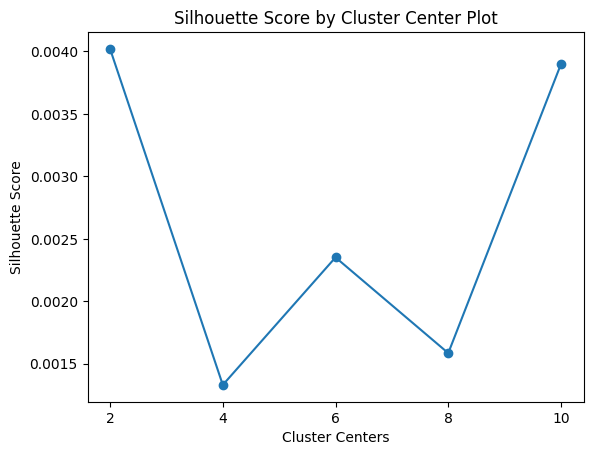

In [4]:
# Find optimal clusters
cf.find_optimal_clusters(text_tfidf, 10)

In [5]:
# Clustering using MiniBatchKMeans
optimal_clusters = 6  # Adjust based on your findings
clusters_tfidf = MiniBatchKMeans(n_clusters=optimal_clusters, init_size=1024, batch_size=2048, random_state=20).fit_predict(text_tfidf)
clusters_kmedoids = KMedoids(n_clusters=optimal_clusters, metric='cosine', random_state=20).fit_predict(text_tfidf)

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


As we can see from the chart above, a silhouette value indicates a decidedly weak/neutral assignment of values to clusters, a score close to 0 indicates observations that are on the borderline of several clusters. However we have decided to move on with analysis and see whether in fact there is no potential clustering method applicable that could categorize the text data in some way. As the optimal choice we have decided to go with 6 clusters, because of the seemingly still low amount of clusters and relatively high silhouette score.



#### KMeedoids Clustering

Below can be seen 2D PCA and t-SNE representation of 6 clusters based on K-Medoids algorithm. The charts tentatively confirm our assumptions about low clusterization potential, especially in 2-dimensional space.

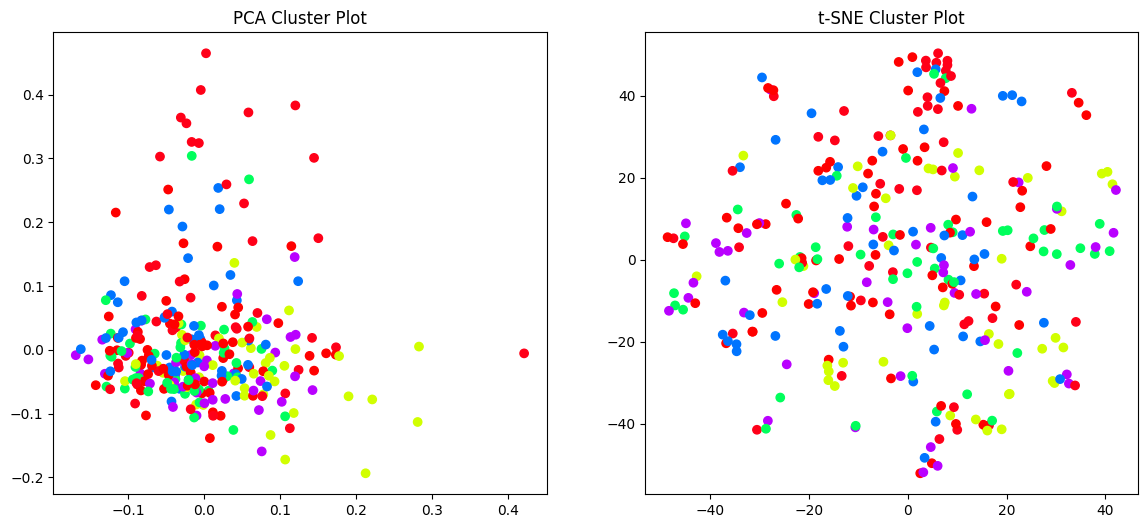

In [6]:
# Plotting PCA and t-SNE
cf.plot_tsne_pca(text_tfidf, clusters_kmedoids)
plt.show()

#### KMeans Clustering

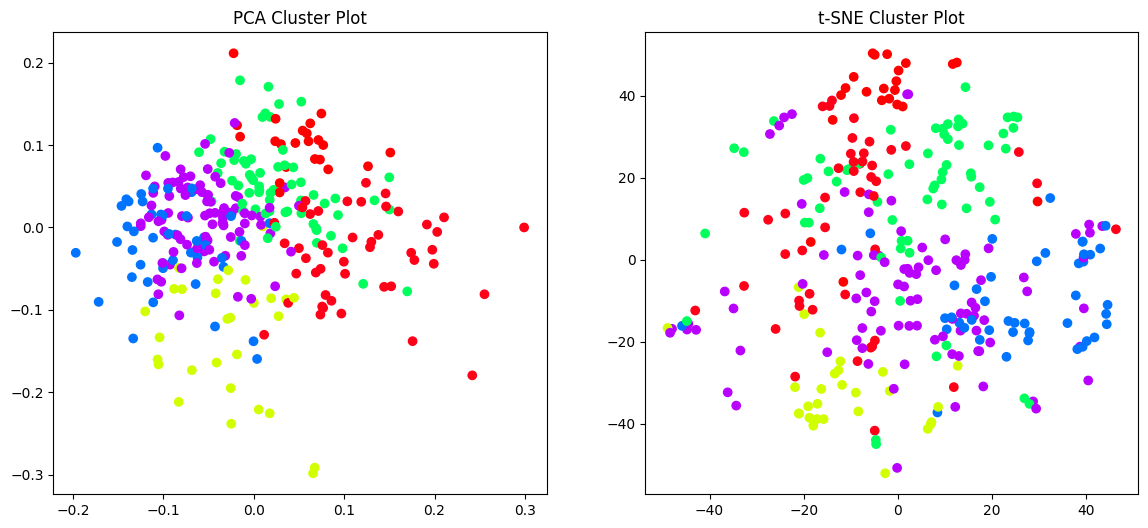

In [7]:
# Plotting PCA and t-SNE
cf.plot_tsne_pca(text_tfidf, clusters_tfidf)
plt.show()

In [8]:
cf.get_top_keywords(text_tfidf, clusters_tfidf, tfidf.get_feature_names_out(), 5)


Cluster 0
day,say,school,teacher,class

Cluster 1
home,road,drive,door,car

Cluster 2
time,like,phone,work,say

Cluster 3
like,shower,bathroom,toilet,water

Cluster 4
happen,look,time,start,like

Cluster 5
talk,like,say,girl,friend


In [9]:
cf.get_top_keywords(text_tfidf, clusters_kmedoids, tfidf.get_feature_names_out(), 5)


Cluster 0
day,feel,like,time,really

Cluster 1
like,talk,girl,school,friend

Cluster 2
make,time,ve,day,work

Cluster 3
guy,say,look,like,phone

Cluster 4
time,know,start,like,say

Cluster 5
start,tell,say,friend,car


#### Assign clusters

In [51]:
df['cluster'] = clusters_tfidf

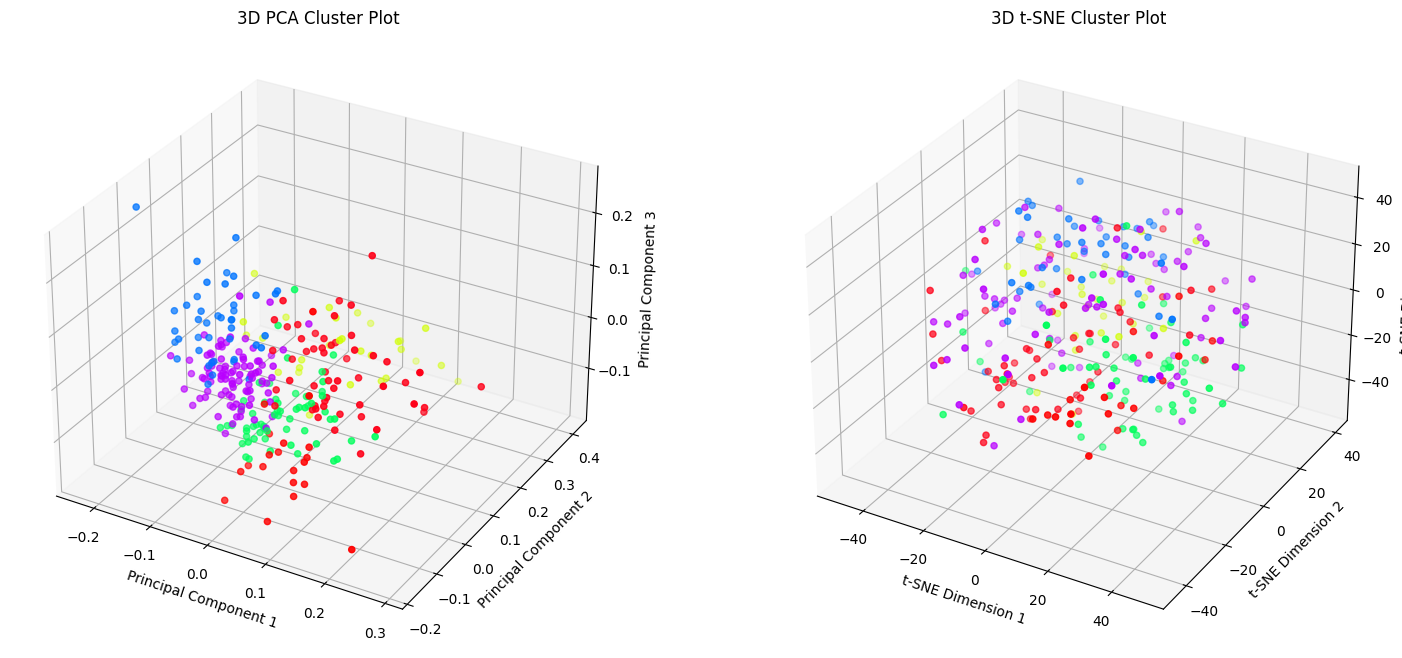

In [10]:
# Call the 3D PCA plot function
cf.plot_3d_pca_tsna(text_tfidf, clusters_tfidf)
#plot_3d_pca_tsna(text_tfidf, clusters_tfidf)

## Word Embedding

As we have already seen how the clustering works using TF-IDF vectorization, let's now try to use word embedding and see whether the clusters are calculated faster and more accurately. 

In [3]:
tokenized_sentences = [sentence.split() for sentence in df['documents_lem']]
model = word2vec.Word2Vec(tokenized_sentences,  vector_size=50, window=5, min_count=1, workers=10)

non_empty_tokenized_sentences = [doc for doc in tokenized_sentences if doc]

embeddings = [np.mean([model.wv[word] for word in doc], axis=0) for doc in tokenized_sentences]
embeddings_np = np.array(embeddings)
data_standardized = StandardScaler().fit_transform(embeddings)

In order to choose the cluster number on embeddings calculate optimal cluster number using silhouette score as an comparison metric.

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 2 clusters - Silhouette Score: 0.11488367638367605


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 4 clusters - Silhouette Score: 0.07326138493570396


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 6 clusters - Silhouette Score: 0.056557173806203585


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 8 clusters - Silhouette Score: 0.05355432031372246


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 10 clusters - Silhouette Score: 0.053998373915118456


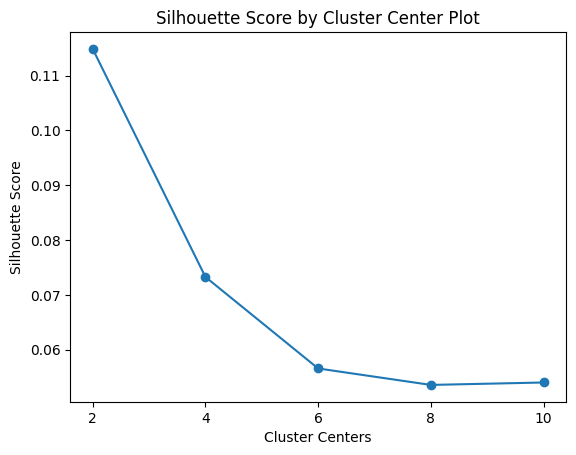

In [6]:
# Assuming 'tokenized_text' is a list of tokenized sentences
cf.find_optimal_clusters_with_embeddings(tokenized_sentences, max_k=10)

##### Clustering on Embeddings [Kmeans]

In [4]:
clusters_kmeans = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, random_state=20).fit_predict(data_standardized)


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


###### 2D Graph [Kmeans]

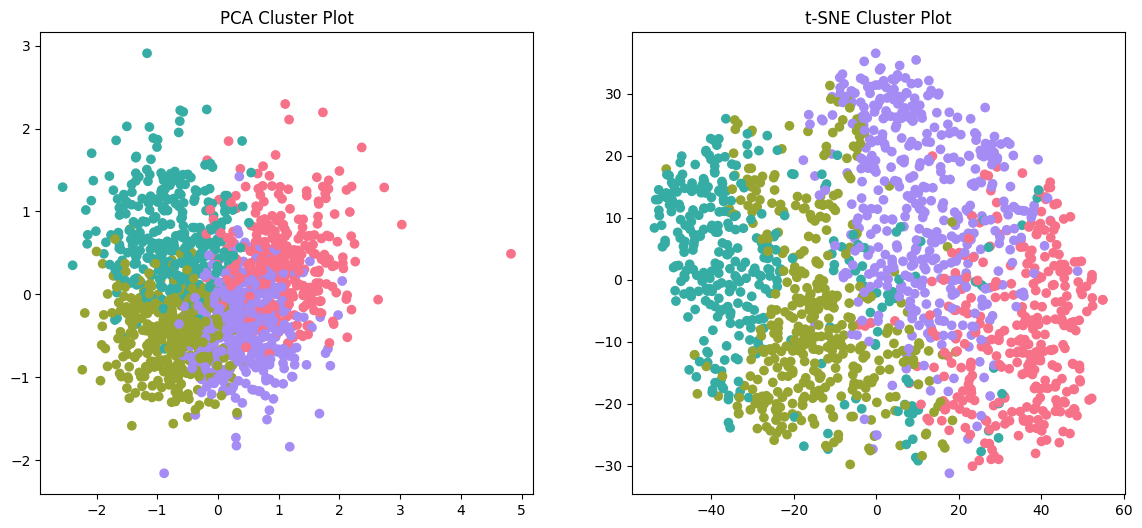

In [6]:
# Plotting PCA and t-SNE
cf.plot_tsne_pca_emb(embeddings_np, clusters_kmeans)


###### 3D Graph [Kmeans]

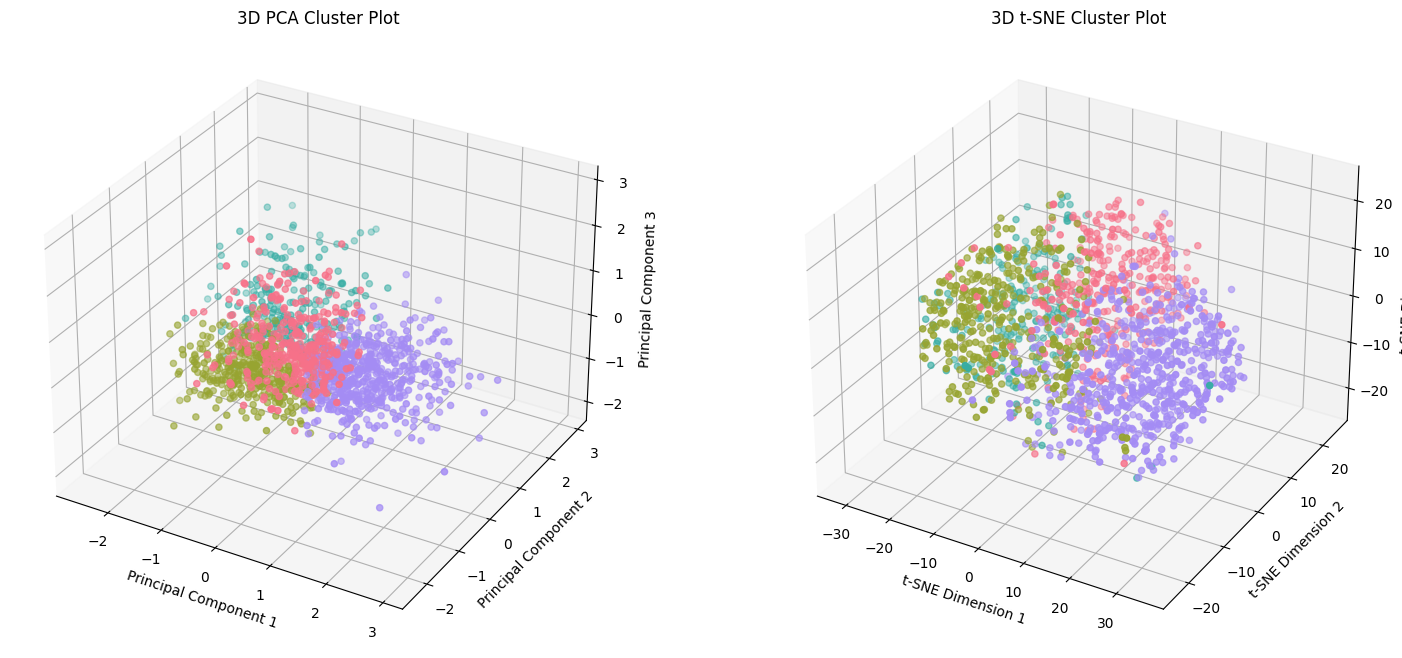

In [5]:
cf.plot_3d_pca_tsna_emb(embeddings_np, clusters_kmeans)

First thing to notice after using the word embedding is the speed of clustering algorithms. Much faster in comparison to previous calculations [using TF-IDF vectorization]
Additionally, the clusters calculate on word embeddings seem to be much better separated plotted on 2 and 3 dimensional space, especially compering them to the previous charts where we were using TF-IDF vectorization technique. The silhouette value (0.075) also resembles better cluster integrity for 4 clusters. 

Let's see now whether calculated clusters contain some cluster specific words/information.

In [14]:
cf.get_top_keywords(text_tfidf, clusters_kmeans, tfidf.get_feature_names_out(), 10)


Cluster 0
try,decide,bathroom,day,hand,make,time,start,water,like

Cluster 1
time,home,start,come,look,friend,say,walk,door,car

Cluster 2
year,start,time,really,know,talk,girl,like,friend,say

Cluster 3
make,use,year,day,time,computer,email,phone,say,work


As an example let's see the differences between specific words between the clusters ;)

In [16]:
print("Cosine similarity between 'day' " + 
               "and 'bathroom': ", model.wv.similarity('bathroom', 'water')) 
print("Cosine similarity between 'day' " + 
               "and 'bathroom': ", model.wv.similarity('bathroom', 'home')) 
print("Cosine similarity between 'day' " + 
               "and 'bathroom': ", model.wv.similarity('bathroom', 'time')) 
print("Cosine similarity between 'day' " + 
               "and 'bathroom': ", model.wv.similarity('bathroom', 'work')) 

Cosine similarity between 'day' and 'bathroom':  0.4629855
Cosine similarity between 'day' and 'bathroom':  0.34674335
Cosine similarity between 'day' and 'bathroom':  0.18174867
Cosine similarity between 'day' and 'bathroom':  0.058329664
